Zaimplementuj własny model rozmyty. Możesz korzystać z bibliotek (numpy itp.) z wyłączeniem bibliotek implementujących systemy rozmyte.

Model powinien pozwalać na:

Zdefiniowanie zmiennych wejściowych wraz z ich zakresem.
Zdefiniowanie na zmiennych wejściowych zbiorów rozmytych wraz z ich nazwą i kształtem funkcji przynależności (trójkątna i trapezoidalna)
Zdefiniowanie reguł opierających się na zmiennych wejściowych i zbiorach na nich opisanych. Wyjście reguły jest wartością liczbową zmiennej wyjściowej (Model TSK 0-rzędu)
Określenie stopnia prawdziwości poprzednika reguły
Określenie wartości zmiennej wyjściowej w oparciu o model wnioskowania TSK
Wykorzystaj zaimplementowany model do określenia wartości napiwku (procentowo, 0-15) na postawie jakości jedzenia (0-10) i jakości obsługi (0-10).

In [44]:
import numpy as np
import copy
import math
import pandas as pd
from matplotlib import pyplot as plt

In [45]:
class Rule():
    def __init__(self, input_1 = list, operator = str, input_2 = list, output = list):
        self.input_1 = input_1
        self.input_2 = input_2
        self.operator = operator
        self.output = output

class Input():
    def __init__(self, input_range: np.ndarray, name: str):
        self.input_range = input_range
        self.name = name
        self.poor = []
        self.average = []
        self.good = []
        self.values = [self.poor, self.average, self.good]

    def auto_tri(self):
        x = self.input_range[-1]
        self.poor = [0, 0, x/2]
        self.average = [0, x/2, x]
        self.good = [x/2, x, x]
        self.values = [self.poor, self.average, self.good]

    def auto_tra(self):
        x = self.input_range[-1]
        bias = x/5
        self.poor = [0, 0, bias, x/2 - bias/2]
        self.average = [bias, x/2 - bias/2, x/2 + bias/2, x - bias]
        self.good = [x/2 + bias/2, x - bias, x, x]
        self.values = [self.poor, self.average, self.good]

class Output():
    def __init__(self, input_range: np.ndarray, name: str):
        self.input_range = input_range
        self.name = name
        self.poor = []
        self.average = []
        self.good = []
        self.values = [self.poor, self.average, self.good]

    def auto_tri(self):
        x = self.input_range[-1]
        self.poor = [0, 0, x/2]
        self.average = [0, x/2, x]
        self.good = [x/2, x, x]
        self.values = [self.poor, self.average, self.good]


    def auto_tra(self):
        x = self.input_range[-1]
        bias = x/5
        self.poor = [0, 0, bias, x/2 - bias/2]
        self.average = [bias, x/2 - bias/2, x/2 + bias/2, x - bias]
        self.good = [x/2 + bias/2, x - bias, x, x]
        self.values = [self.poor, self.average, self.good]

class FuzzyModel():
    def __init__(self, inputs_values: dict, inputs_dict: dict, rules: list, output: Output):
        self.rules = rules
        self.inputs_dict = inputs_dict
        self.output = output
        self.inputs_values = inputs_values
        self.inputs_membered = dict()
        self.output_membered = dict()
        self.y_array = None

    def singular_membership(self, value: float, ranges: list) -> float:
        if len(ranges) == 3:
            a, b, c = ranges

            if value <= b:
                max_value = b - value
                min_value = value - a
                sum_values = min_value + max_value
                if sum_values == 0:
                    return 1
                membership = round(min_value / sum_values, 5)
                if membership < 0: return 0
                return membership

            max_value = c - value
            min_value = value - b
            sum_values = min_value + max_value
            if sum_values == 0:
                    return 1
            membership = round(max_value / sum_values, 5)
            if membership < 0: return 0
            return membership

        if len(ranges) == 4:
            a, b, c, d = ranges

            if b < value <= c:
                return 1

            elif c < value <= d:
                max_value = d - value
                min_value = value - c
                sum_values = min_value + max_value
                if sum_values == 0:
                    return 1
                membership = round(max_value / sum_values, 5)
                return membership

            elif a < value <= b:
                max_value = b - value
                min_value = value - a
                sum_values = min_value + max_value
                if sum_values == 0:
                    return 1
                membership = round(min_value / sum_values, 5)
                return membership

            return 0


    def membership_function(self):
        for input in list(self.inputs_values.keys()):
            inputs_membered_list = []
            for fuzzy_variable in range(len(self.inputs_dict[input].values)):
                inputs_membered_list.append(self.singular_membership(self.inputs_values[input], self.inputs_dict[input].values[fuzzy_variable]))

            self.inputs_membered[input] = inputs_membered_list


    def deposit_rule_on_output(self, x_array: np.array, global_y_array: np.array, rule: Rule):

        temp_y_array = copy.deepcopy(global_y_array)

        match rule.input_1[1]:
            case 'poor':
                index_1 = 0
            case 'average':
                index_1 = 1
            case 'good':
                index_1 = 2

        match rule.input_2[1]:
            case 'poor':
                index_2 = 0
            case 'average':
                index_2 = 1
            case 'good':
                index_2 = 2

        match rule.output[1]:
            case 'poor':
                index_output = 0
            case 'average':
                index_output = 1
            case 'good':
                index_output = 2

        match rule.operator:
            case 'AND':
                cut = min(self.inputs_membered[rule.input_1[0]][index_1], self.inputs_membered[rule.input_2[0]][index_2])
            case 'OR':
                cut = max(self.inputs_membered[rule.input_1[0]][index_1], self.inputs_membered[rule.input_2[0]][index_2])

        for sample in range(len(x_array)):
            temp_y_array[sample] = self.singular_membership(x_array[sample], self.output.values[index_output])

        cut_y_array = np.where(temp_y_array > cut, cut, temp_y_array)
        return np.where(global_y_array >= cut_y_array, global_y_array, cut_y_array)

    def calculate(self):
        x_array = copy.deepcopy(self.output.input_range)
        global_y_array = np.zeros(x_array.shape[0])

        for rule in rules:
            global_y_array = self.deposit_rule_on_output(x_array, global_y_array, rule)

        self.y_array = global_y_array

    def output_value(self):
        value = 0
        value += sum([self.output.input_range[x] * self.y_array[x] for x in range(len(self.output.input_range))])

        return round(value/sum(self.y_array), 2)

In [46]:
quality = Input(np.arange(0, 10.1, 0.1), 'quality')
service = Input(np.arange(0, 10.1, 0.1), 'service')
tip = Output(np.arange(0, 15.1, 0.1), 'tip')

inputs_dict = {
'quality': quality,
'service': service}

In [47]:
quality.auto_tri()
service.auto_tri()
tip.auto_tri()

In [48]:
inputs_values = {'quality': 5.5,
               'service': 2.5}

rules = [Rule(['quality', 'poor'], 'AND', ['service', 'poor'], ['tip', 'poor']),
         Rule(['quality', 'poor'], 'AND', ['service', 'average'], ['tip', 'poor']),
         Rule(['quality', 'average'], 'AND', ['service', 'poor'], ['tip', 'poor']),
         Rule(['quality', 'poor'], 'AND', ['service', 'good'], ['tip', 'average']),
         Rule(['quality', 'good'], 'AND', ['service', 'poor'], ['tip', 'average']),
         Rule(['quality', 'average'], 'AND', ['service', 'average'], ['tip', 'average']),
         Rule(['quality', 'good'], 'AND', ['service', 'average'], ['tip', 'good']),
         Rule(['quality', 'average'], 'AND', ['service', 'good'], ['tip', 'good']),
         Rule(['quality', 'good'], 'AND', ['service', 'good'], ['tip', 'good']),
         ]

In [49]:
model = FuzzyModel(inputs_values=inputs_values, inputs_dict=inputs_dict, rules=[], output=tip)
model.membership_function()
model.inputs_membered

{'quality': [0, 0.9, 0.1], 'service': [0.5, 0.5, 0]}

In [50]:
model.calculate()

In [51]:
model.output_value()

6.63

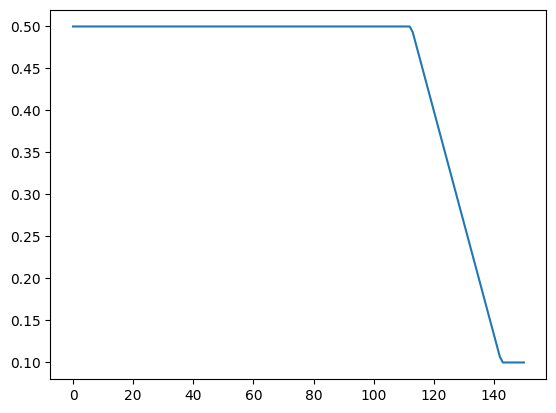

In [52]:
x_list, y_list = list(), list()
for x, y in enumerate(model.y_array):
    x_list.append(x)
    y_list.append(y)

plt.plot(x_list, y_list)
plt.show()

In [53]:
service.values

[[0, 0, 5.0], [0, 5.0, 10.0], [5.0, 10.0, 10.0]]

In [54]:
model.inputs_values

{'quality': 5.5, 'service': 2.5}